In [1]:
import pandas as pd
import pyspark
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

import os
import re

dpath = os.path.expanduser('~/Dropbox/Projects/data/')

In [2]:
%load_ext autotime

In [40]:
SparkContext.version

time: 991 µs


In [42]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

time: 2.46 ms


In [10]:
def csvParse(s):
    import csv
    from StringIO import StringIO
    sio = StringIO(s)
    value = csv.reader(sio).next()
    sio.close()
    return value

inspections = sc.textFile(dpath + 'HdiSamples/Foodinspection/csv/Food_Inspections1.csv')\
                .map(csvParse)

inspections.take(1)

[['413707',
  'LUNA PARK INC',
  'LUNA PARK  DAY CARE',
  '2049789',
  "Children's Services Facility",
  'Risk 1 (High)',
  '3250 W FOSTER AVE ',
  'CHICAGO',
  'IL',
  '60625',
  '09/21/2010',
  'License-Task Force',
  'Fail',
  '24. DISH WASHING FACILITIES: PROPERLY DESIGNED, CONSTRUCTED, MAINTAINED, INSTALLED, LOCATED AND OPERATED - Comments: All dishwashing machines must be of a type that complies with all requirements of the plumbing section of the Municipal Code of Chicago and Rules and Regulation of the Board of Health. OBSEVERD THE 3 COMPARTMENT SINK BACKING UP INTO THE 1ST AND 2ND COMPARTMENT WITH CLEAR WATER AND SLOWLY DRAINING OUT. INST NEED HAVE IT REPAIR. CITATION ISSUED, SERIOUS VIOLATION 7-38-030 H000062369-10 COURT DATE 10-28-10 TIME 1 P.M. ROOM 107 400 W. SURPERIOR. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: Shielding to protect against broken glass falling into food shall be provided for all artificial lighting sourc

time: 590 ms


In [41]:
inspections = spark.read.options(header='true', inferSchema='true', delimiter='|')\
    .csv(dpath + 'HdiSamples/Foodinspection/csv/Food_Inspections1.csv')
inspections.show(1)

AnalysisException: u'Unable to resolve 413707,LUNA PARK INC,LUNA PARK  DAY CARE,2049789,Children\'s Services Facility,Risk 1 (High),3250 W FOSTER AVE ,CHICAGO,IL,60625,09/21/2010,License-Task Force,Fail,"24. DISH WASHING FACILITIES: PROPERLY DESIGNED, CONSTRUCTED, MAINTAINED, INSTALLED, LOCATED AND OPERATED - Comments: All dishwashing machines must be of a type that complies with all requirements of the plumbing section of the Municipal Code of Chicago and Rules and Regulation of the Board of Health. OBSEVERD THE 3 COMPARTMENT SINK BACKING UP INTO THE 1ST AND 2ND COMPARTMENT WITH CLEAR WATER AND SLOWLY DRAINING OUT. INST NEED HAVE IT REPAIR. CITATION ISSUED, SERIOUS VIOLATION 7-38-030 H000062369-10 COURT DATE 10-28-10 TIME 1 P.M. ROOM 107 400 W. SURPERIOR.  given [413707,LUNA PARK INC,LUNA PARK  DAY CARE,2049789,Children\'s Services Facility,Risk 1 (High),3250 W FOSTER AVE ,CHICAGO,IL,60625,09/21/2010,License-Task Force,Fail,"24. DISH WASHING FACILITIES: PROPERLY DESIGNED, CONSTRUCTED, MAINTAINED, INSTALLED, LOCATED AND OPERATED - Comments: All dishwashing machines must be of a type that complies with all requirements of the plumbing section of the Municipal Code of Chicago and Rules and Regulation of the Board of Health. OBSEVERD THE 3 COMPARTMENT SINK BACKING UP INTO THE 1ST AND 2ND COMPARTMENT WITH CLEAR WATER AND SLOWLY DRAINING OUT. INST NEED HAVE IT REPAIR. CITATION ISSUED, SERIOUS VIOLATION 7-38-030 H000062369-10 COURT DATE 10-28-10 TIME 1 P.M. ROOM 107 400 W. SURPERIOR. ,  36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: Shielding to protect against broken glass falling into food shall be provided for all artificial lighting sources in preparation, service, and display facilities. LIGHT SHIELD ARE MISSING UNDER HOOD OF  COOKING EQUIPMENT AND NEED TO REPLACE LIGHT UNDER UNIT. 4 LIGHTS ARE OUT IN THE REAR CHILDREN AREA,IN THE KINDERGARDEN CLASS ROOM. 2 LIGHT ARE OUT EAST REAR, LIGHT FRONT WEST ROOM. NEED TO REPLACE ALL LIGHT THAT ARE NOT WORKING. ,  35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: The walls and ceilings shall be in good repair and easily cleaned. MISSING CEILING TILES WITH STAINS IN WEST,EAST, IN FRONT AREA WEST, AND BY THE 15MOS AREA. NEED TO BE REPLACED. ,  32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: All food and non-food contact equipment and utensils shall be smooth, easily cleanable, and durable, and shall be in good repair. SPLASH GUARDED ARE NEEDED BY THE EXPOSED HAND SINK IN THE KITCHEN AREA ,  34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: The floors shall be constructed per code, be smooth and easily cleaned, and be kept clean and in good repair. INST NEED TO ELEVATE ALL FOOD ITEMS 6INCH OFF THE FLOOR 6 INCH AWAY FORM WALL.  ",41.97583445690982,-87.7107455232781,"(41.97583445690982, -87.7107455232781)"];'

time: 212 ms


In [11]:
schema = StructType([
StructField("id", IntegerType(), False), 
StructField("name", StringType(), False), 
StructField("results", StringType(), False), 
StructField("violations", StringType(), True)])

df = sqlContext.createDataFrame(inspections.map(lambda l: (int(l[0]), l[1], l[12], l[13])) , schema)
# df.registerTempTable('CountResults')

time: 291 ms


In [12]:
df.show(5)

+------+--------------------+-------+--------------------+
|    id|                name|results|          violations|
+------+--------------------+-------+--------------------+
|413707|       LUNA PARK INC|   Fail|24. DISH WASHING ...|
|391234|       CAFE SELMARIE|   Fail|2. FACILITIES TO ...|
|413751|          MANCHU WOK|   Pass|33. FOOD AND NON-...|
|413708|BENCHMARK HOSPITA...|   Pass|                    |
|413722|           JJ BURGER|   Pass|                    |
+------+--------------------+-------+--------------------+
only showing top 5 rows

time: 342 ms


In [13]:
df.select('results').distinct().show()

+--------------------+
|             results|
+--------------------+
|                Fail|
|Business Not Located|
|  Pass w/ Conditions|
|     Out of Business|
|                Pass|
+--------------------+

time: 1.01 s


In [19]:
countResultsdf = df.groupby('results').count().withColumnRenamed('count', 'cnt')
countResultsdf.show()

+--------------------+----+
|             results| cnt|
+--------------------+----+
|                Fail|3324|
|Business Not Located|   6|
|  Pass w/ Conditions|1033|
|     Out of Business| 281|
|                Pass|8457|
+--------------------+----+

time: 528 ms


ValueError: setting an array element with a sequence.

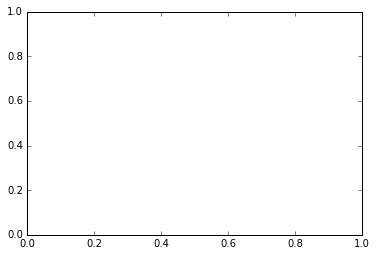

time: 282 ms


In [20]:
# %%local
%matplotlib inline
import matplotlib.pyplot as plt

labels = countResultsdf['results']
sizes = countResultsdf['cnt']
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')

In [21]:
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData = df.select(label(df.results).alias('label'), df.violations).where('label >= 0')

labeledData.take(1)

[Row(label=0.0, violations=u'24. DISH WASHING FACILITIES: PROPERLY DESIGNED, CONSTRUCTED, MAINTAINED, INSTALLED, LOCATED AND OPERATED - Comments: All dishwashing machines must be of a type that complies with all requirements of the plumbing section of the Municipal Code of Chicago and Rules and Regulation of the Board of Health. OBSEVERD THE 3 COMPARTMENT SINK BACKING UP INTO THE 1ST AND 2ND COMPARTMENT WITH CLEAR WATER AND SLOWLY DRAINING OUT. INST NEED HAVE IT REPAIR. CITATION ISSUED, SERIOUS VIOLATION 7-38-030 H000062369-10 COURT DATE 10-28-10 TIME 1 P.M. ROOM 107 400 W. SURPERIOR. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: Shielding to protect against broken glass falling into food shall be provided for all artificial lighting sources in preparation, service, and display facilities. LIGHT SHIELD ARE MISSING UNDER HOOD OF  COOKING EQUIPMENT AND NEED TO REPLACE LIGHT UNDER UNIT. 4 LIGHTS ARE OUT IN THE REAR CHILDREN AREA,IN THE KIND

time: 593 ms


In [44]:
tokenizer = Tokenizer(inputCol="violations", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, lr])

model = pipeline.fit(labeledData)

time: 4.36 s


In [45]:
testData = sc.textFile(dpath + 'HdiSamples/Foodinspection/csv/Food_Inspections2.csv')\
         .map(csvParse) \
         .map(lambda l: (int(l[0]), l[1], l[12], l[13]))
testDf = sqlContext.createDataFrame(testData, schema).where("results = 'Fail' OR results = 'Pass' OR results = 'Pass w/ Conditions'")
predictionsDf = model.transform(testDf)
predictionsDf.registerTempTable('Predictions')
predictionsDf.columns

['id',
 'name',
 'results',
 'violations',
 'words',
 'filtered',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

time: 113 ms


In [46]:
predictionsDf.take(1)

[Row(id=580320, name=u"COUSIN'S GRILL", results=u'Fail', violations=u'37. TOILET ROOM DOORS SELF CLOSING: DRESSING ROOMS WITH LOCKERS PROVIDED: COMPLETE SEPARATION FROM LIVING/SLEEPING QUARTERS - Comments: INSTRUCTED TO FIX BROKEN SELF CLOSING DEVICE AT WASHROOM DOOR. | 40. REFRIGERATION AND METAL STEM THERMOMETERS PROVIDED AND CONSPICUOUS - Comments: All food establishments that display, prepare, or store potentially hazardous foods shall have calibrated metal stem thermometers, provided and conspicuous, for refrigerated and hot food units.  INSTRUCTED TO PROVIDE THERMOMETTER VISIBLE INSIDE ALL COOLERS. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: Shielding to protect against broken glass falling into food shall be provided for all artificial lighting sources in preparation, service, and display facilities.  LIGHTBULBS MUST BE SHIELDED INSIDE HOT HOLDING DISPLAY UNIT OR PROVIDE SHATTERFROOFED LIGHTBULB.   | 18. NO EVIDENCE OF RODENT OR

time: 93.8 ms


In [47]:
numSuccesses = predictionsDf.where("""(prediction = 0 AND results = 'Fail') OR 
                                      (prediction = 1 AND (results = 'Pass' OR 
                                                           results = 'Pass w/ Conditions'))""").count()
numInspections = predictionsDf.count()

print "There were", numInspections, "inspections and there were", numSuccesses, "successful predictions"
print "This is a", str((float(numSuccesses) / float(numInspections)) * 100) + "%", "success rate"
# removing stopwords resulted in slightly lower success rate. 

There were 9315 inspections and there were 8102 successful predictions
This is a 86.9779924852% success rate
time: 1.94 s


In [32]:
true_positive = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND results = 'Fail'")

false_positive = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND (results = 'Pass' OR results = 'Pass w/ Conditions')")

true_negative = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND results = 'Fail'")

false_negative = spark.sql("SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND (results = 'Pass' OR results = 'Pass w/ Conditions')") 

time: 45.1 ms


ValueError: setting an array element with a sequence.

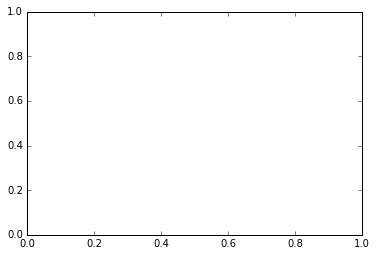

time: 214 ms


In [34]:

%matplotlib inline
import matplotlib.pyplot as plt

labels = ['True positive', 'False positive', 'True negative', 'False negative']
sizes = [true_positive['cnt'], false_positive['cnt'], false_negative['cnt'], true_negative['cnt']]
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')